In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import resampy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [2]:
import os
os.getcwd()

'/Users/urmitmahida34/Downloads'

In [3]:
filename='/Users/urmitmahida34/Downloads/drill.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(filename)
print(librosa_audio_data)

[-0.08862758 -0.06993043 -0.1128544  ... -0.00269884 -0.07219736
 -0.04009289]


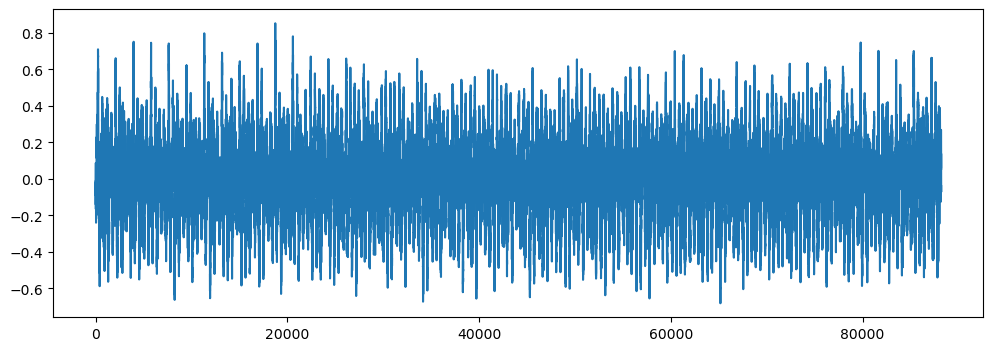

In [4]:
# audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [5]:
librosa_audio_data.shape

(88200,)

In [6]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(filename)

In [7]:
wave_audio

array([[-5410, -4107],
       [-3069, -1669],
       [-3002,  -580],
       ...,
       [ -843, -2950],
       [ -246, -2356],
       [ -653, -1872]], dtype=int16)

In [8]:
wave_audio.shape

(176400, 2)

In [9]:
wave_sample_rate

44100

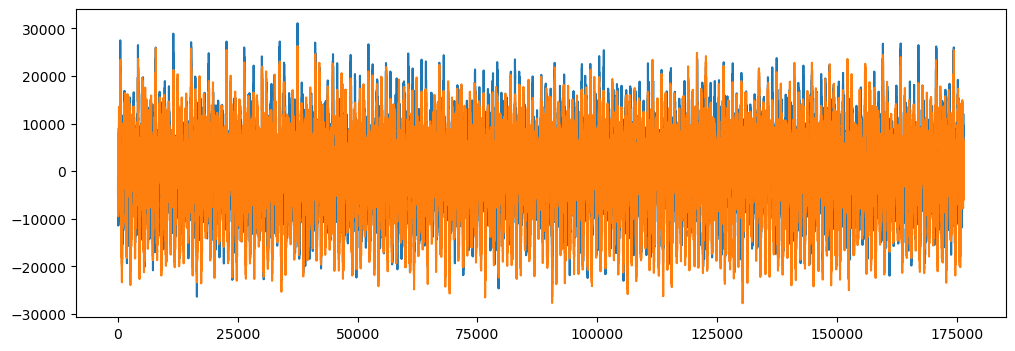

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

In [11]:
import pandas as pd

metadata=pd.read_csv('/Users/urmitmahida34/Downloads/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [12]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

**Extract Features**

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [13]:
# Compute Mel-frequency cepstral coefficients (MFCCs) from the input audio data using Librosa.
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [14]:
mfccs

array([[-8.9347023e+01, -5.7442360e+01, -4.7769444e+01, ...,
        -5.5271309e+01, -5.6489330e+01, -6.8862465e+01],
       [ 7.9567230e+01,  8.0716034e+01,  8.0969391e+01, ...,
         7.2533684e+01,  6.9103760e+01,  7.0544998e+01],
       [ 3.4342079e+01,  3.4006599e+01,  3.0572533e+01, ...,
         3.1363997e+01,  3.5402344e+01,  3.2892380e+01],
       ...,
       [ 8.7123919e+00,  1.0009290e+01,  8.1983519e+00, ...,
         3.4209778e+00,  9.6206226e+00,  1.0333674e+01],
       [ 1.0601497e+00,  1.5120957e+00, -3.0839682e-02, ...,
        -4.6075468e+00,  1.2902256e+00,  1.5484858e+00],
       [ 5.1671228e+00,  2.3602567e+00,  2.3520555e-01, ...,
         3.5476434e-01,  2.1036274e+00,  3.8536124e+00]], dtype=float32)

In [15]:
audio_dataset_path='/Users/urmitmahida34/Downloads/UrbanSound8K/audio/'

In [16]:
# This function uses Librosa to extract Mel-Frequency Cepstral Coefficients (MFCCs) features from an audio file, then scales and 
# returns the mean of these features.

def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

#### Below Cell iterates through each row in the metadata DataFrame, extracts features using Mel-Frequency Cepstral Coefficients (MFCCs) from the corresponding audio file, and appends the extracted features along with their class labels to a list. 
#### The tqdm library is used to display a progress bar while iterating through the rows.

In [17]:
from tqdm import tqdm
import resampy
# Now we iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3553it [02:06, 29.94it/s]/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [04:43, 39.82it/s]/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [04:56, 29.50it/s]


In [18]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22339, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402218, 60.302044,...",children_playing


In [19]:
extracted_features_df['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [20]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [21]:
X.shape

(8732, 40)

In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [23]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [24]:
y.shape

(8732, 10)

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [26]:
X_train

array([[-1.31104706e+02,  1.12505905e+02, -2.25746956e+01, ...,
         3.24665213e+00, -1.36902368e+00,  2.75575471e+00],
       [-1.36703424e+01,  9.10850830e+01, -7.79273319e+00, ...,
        -3.25305033e+00, -5.27745295e+00, -1.55697155e+00],
       [-4.98715439e+01,  2.65352994e-01, -2.05009365e+01, ...,
         2.85459447e+00, -1.60920441e+00,  3.52480578e+00],
       ...,
       [-4.27012360e+02,  9.26230469e+01,  3.12939739e+00, ...,
         7.42641211e-01,  7.33490884e-01,  7.11009264e-01],
       [-1.45754608e+02,  1.36265778e+02, -3.35155182e+01, ...,
         1.46811938e+00, -2.00917006e+00, -8.82181883e-01],
       [-4.21031342e+02,  2.10654541e+02,  3.49066091e+00, ...,
        -5.38886738e+00, -3.37136054e+00, -1.56651139e+00]], dtype=float32)

In [27]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [28]:
X_train.shape

(6985, 40)

In [29]:
X_test.shape

(1747, 40)

In [30]:
y_train.shape

(6985, 10)

In [31]:
y_test.shape

(1747, 10)

In [32]:
num_labels=y.shape[1]
num_labels

10

In [37]:
'''This cell defines a feedforward neural network with three hidden layers, each using ReLU activation and dropout regularization. 
The final layer applies softmax activation for multi-class classification.
'''

model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 100)            │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,410 (177.38 KB)

 Trainable params: 45,410 (177.38 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

#### This code trains a neural network model using the provided training data (X_train and y_train) for a 100 epochs and batch size = 32. validation of the model on the test data (X_test and y_test) done and finally saving the best-performing model during training using the ModelCheckpoint callback

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification_best_model.keras',
                               verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
201/219 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.1121 - loss: 23.9713 
Epoch 1: val_loss improved from inf to 2.29091, saving model to saved_models/audio_classification_best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.1123 - loss: 22.8699 - val_accuracy: 0.1070 - val_loss: 2.2909
Epoch 2/100
178/219 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.1207 - loss: 2.6082
Epoch 2: val_loss improved from 2.29091 to 2.28069, saving model to saved_models/audio_classification_best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.1196 - loss: 2.5906 - val_accuracy: 0.1070 - val_loss: 2.2807
Epoch 3/100
204/219 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.1159 - loss: 2.3703
Epoch 3: val_loss improved from 2.28069 to 2.27448, saving model to saved_models/audio_classification_best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.1158 - loss: 2.3677 - val_accuracy: 0.1070 - val_loss: 2.2745
Epoch 4/100
207/219 

In [43]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7458500266075134


In [52]:
filename = "/Users/urmitmahida34/Downloads/54823-3-1-0.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_probabilities = model.predict(mfccs_scaled_features)
print(predicted_probabilities)
predicted_class_names = labelencoder.inverse_transform(np.argmax(predicted_probabilities, axis=1))
print("Predicted class:", predicted_class_names[0])

[-3.38437195e+02  1.62343979e+02 -5.48527946e+01 -4.44185982e+01
 -1.82701206e+01 -4.17152405e+00 -7.91700506e+00 -1.04257793e+01
  2.68847203e+00  2.35184937e+01  1.44816341e+01  1.86040344e+01
  1.72385235e+01  2.57122946e+00 -1.06023760e+01  5.18918848e+00
  5.28340960e+00 -1.64382493e+00 -4.68882704e+00 -3.08302259e+00
  2.71611214e-01  8.34154892e+00 -1.83543295e-01  3.53950799e-01
 -3.75215113e-01  3.26864076e+00 -3.64307237e+00 -1.69564974e+00
  2.44028044e+00 -3.64270061e-01 -5.46928549e+00  1.03643715e-01
  2.95129895e+00  2.43590474e-02  2.03075719e+00 -1.58548975e+00
 -1.02153385e+00  7.25347519e-01  2.49539351e+00  9.19067919e-01]
[[-3.38437195e+02  1.62343979e+02 -5.48527946e+01 -4.44185982e+01
  -1.82701206e+01 -4.17152405e+00 -7.91700506e+00 -1.04257793e+01
   2.68847203e+00  2.35184937e+01  1.44816341e+01  1.86040344e+01
   1.72385235e+01  2.57122946e+00 -1.06023760e+01  5.18918848e+00
   5.28340960e+00 -1.64382493e+00 -4.68882704e+00 -3.08302259e+00
   2.71611214e-01  


### This code defines a neural network model using Keras Sequential API with multiple hidden layers, including Dense, BatchNormalization, and Dropout layers. It configures the model for training using the Adam optimizer and categorical cross-entropy loss. Additionally, it implements custom callbacks for model checkpointing, learning rate reduction, and early stopping during training. 

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from datetime import datetime
import os

num_epochs = 200
num_batch_size = 32

model_1 = Sequential([
    Dense(512, input_shape=(40,), activation='relu'),
    BatchNormalization(),  # Add batch normalization layer
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),  # Add batch normalization layer
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),  # Add batch normalization layer
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),  # Add batch normalization layer
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

class CustomModelCheckpoint(Callback):
    def __init__(self, model, filepath_template, monitor='val_loss', save_best_only=False):
        super(CustomModelCheckpoint, self).__init__()
        self._model = model  # Set the model as an instance attribute
        self.filepath_template = filepath_template
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.best_value = None

    @property
    def model(self):
        return self._model

    def on_epoch_end(self, epoch, logs=None):
        filepath = self.filepath_template.format(epoch=epoch + 1, **logs)
        if self.save_best_only:
            current_value = logs.get(self.monitor)
            if current_value is None:
                pass
            elif self.best_value is None or current_value > self.best_value:
                self.best_value = current_value
                self.model.save(filepath)
        else:
            self.model.save(filepath)


filepath_template = 'saved_models/audio_classification_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras'

checkpointer = CustomModelCheckpoint(model=model_1, filepath_template=filepath_template, monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_1.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(X_test, y_test), callbacks=[checkpointer, reduce_lr, early_stopping], verbose=1)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2097 - loss: 2.8254 - val_accuracy: 0.4969 - val_loss: 1.5096 - learning_rate: 0.0010
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3684 - loss: 1.9044 - val_accuracy: 0.5575 - val_loss: 1.2917 - learning_rate: 0.0010
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4605 - loss: 1.6112 - val_accuracy: 0.5993 - val_loss: 1.1837 - learning_rate: 0.0010
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4911 - loss: 1.4624 - val_accuracy: 0.6382 - val_loss: 1.0918 - learning_rate: 0.0010
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5181 - loss: 1.3941 - val_accuracy: 0.6337 - val_loss: 1.0560 - learning_rate: 0.0010
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5639 - loss: 1.2747 - val_accuracy: 0.6817 - val_loss: 0.9758 - learning_rate: 0.0010
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5707 - loss: 1.

In [50]:
test_accuracy=model_1.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9135661125183105


## Test model on unseen data
### Below cell loads an audio file, computes its Mel-Frequency Cepstral Coefficients (MFCCs) features using librosa, scales the features, and reshapes them into a format suitable for prediction by the trained model. Finally, it predicts the class label of the audio file using the trained model and prints the predicted class name.

In [51]:
filename = "/Users/urmitmahida34/Downloads/54823-3-1-0.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_probabilities = model_1.predict(mfccs_scaled_features)
print(predicted_probabilities)
predicted_class_names = labelencoder.inverse_transform(np.argmax(predicted_probabilities, axis=1))
print("Predicted class:", predicted_class_names[0])

[-3.38437195e+02  1.62343979e+02 -5.48527946e+01 -4.44185982e+01
 -1.82701206e+01 -4.17152405e+00 -7.91700506e+00 -1.04257793e+01
  2.68847203e+00  2.35184937e+01  1.44816341e+01  1.86040344e+01
  1.72385235e+01  2.57122946e+00 -1.06023760e+01  5.18918848e+00
  5.28340960e+00 -1.64382493e+00 -4.68882704e+00 -3.08302259e+00
  2.71611214e-01  8.34154892e+00 -1.83543295e-01  3.53950799e-01
 -3.75215113e-01  3.26864076e+00 -3.64307237e+00 -1.69564974e+00
  2.44028044e+00 -3.64270061e-01 -5.46928549e+00  1.03643715e-01
  2.95129895e+00  2.43590474e-02  2.03075719e+00 -1.58548975e+00
 -1.02153385e+00  7.25347519e-01  2.49539351e+00  9.19067919e-01]
[[-3.38437195e+02  1.62343979e+02 -5.48527946e+01 -4.44185982e+01
  -1.82701206e+01 -4.17152405e+00 -7.91700506e+00 -1.04257793e+01
   2.68847203e+00  2.35184937e+01  1.44816341e+01  1.86040344e+01
   1.72385235e+01  2.57122946e+00 -1.06023760e+01  5.18918848e+00
   5.28340960e+00 -1.64382493e+00 -4.68882704e+00 -3.08302259e+00
   2.71611214e-01  